# Dataset Comparison

### Imports

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Load Data

In [47]:
folder_path = os.path.join('..', 'processed_data')
file_names = ['OhioT1DM_imputed.csv', 'tidepool_dataset.csv', 'T1DEXI.csv', 'T1DEXIP.csv']

datasets = {}
for dataset_name in file_names:
    df = pd.read_csv(os.path.join(folder_path, dataset_name), index_col='date', parse_dates=['date'], low_memory=False)
    
    all_dfs = []
    # Trim data in beginning and end of each subject test / train 
    for subject_id, subset_df in df.groupby('id'): 
        for is_test in [False, True]:
            subject_split_df = subset_df[subset_df['is_test'] == is_test]
            
            cgm_col = 'CGM_smoothed' if 'CGM_smoothed' in subject_split_df.columns else 'CGM'
            first_valid_index = subject_split_df[cgm_col].first_valid_index()
            last_valid_index = subject_split_df[cgm_col].last_valid_index()
            if first_valid_index is not None and last_valid_index is not None:
                trimmed_subject_data = subject_split_df.loc[first_valid_index:last_valid_index]
                all_dfs.append(trimmed_subject_data)
            else:
                print("No data, skipping subject...")
    df = pd.concat(all_dfs)
    datasets[dataset_name.split('.')[0]] = df

No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipp

### Print Dataset Key Numbers

In [50]:
def print_numbers_for_datasets(df):
    n = len(df['id'].unique())
    total_samples_in_years = df['CGM'].notna().shape[0] / 12 / 24 / 365 # in years!
    
    if n == 0:
        average_per_subject = 0
    else:
        average_per_subject = total_samples_in_years * 365 / 30 / n
    
    # For the standard deviation, calculate the time span for each subject and then find the std
    time_span_per_subject = df[df['CGM'].notna()].groupby('id').size() / (12 * 24 * 30)
    std_time_span = np.std(time_span_per_subject)

    print(f"n={n}, total samples={total_samples_in_years:.1f} years, average time span={average_per_subject:.1f} months, std={std_time_span:.1f}")


In [51]:
for key in datasets:
    print(key)
    print_numbers_for_datasets(datasets[key])    

OhioT1DM_imputed
n=12, total samples=1.8 years, average time span=1.8 months, std=0.1
tidepool_dataset
n=300, total samples=286.5 years, average time span=11.6 months, std=7.6
T1DEXI
n=409, total samples=30.6 years, average time span=0.9 months, std=0.1
T1DEXIP
n=211, total samples=5.9 years, average time span=0.3 months, std=0.1


### Histogram for Number of Samples per Unique Subject ID

In [52]:
def plot_feature_samples_per_subject(df, column, save_fig=False):
    # Group by 'id' and count non-null 'CGM' values
    counts = df.groupby('id')[f'{column}'].count()
    
    # Plot histogram
    plt.figure(figsize=(8, 2))
    plt.hist(counts, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel(f'Number of {column} Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} samples per ID')
    
    plt.show()
    
    if save_fig:
        plt.savefig(f'{column}_feature_samples_per_subject.png')

In [53]:
df_list = []
for key in datasets:
    df_list.append(datasets[key])

concat_df = pd.concat(df_list)

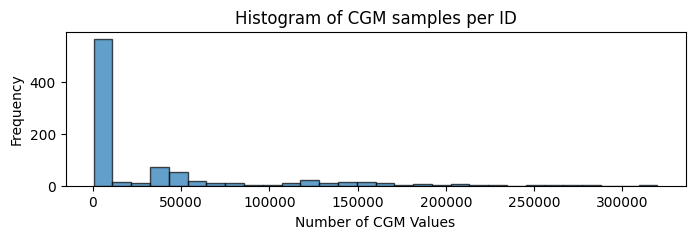

In [54]:
plot_feature_samples_per_subject(concat_df, 'CGM')

### Feature Sparsity

In [73]:
def draw_sparsity_matrix(dataset_dict):
    sparsity_matrix = {}
    
    for name, df in dataset_dict.items():
        if 'CGM_smoothed' in df.columns:
            df = df.copy()
            df['CGM'] = df['CGM_smoothed']
        columns = [col for col in df.columns if not 'id' in col and not 'is_test' in col and not 'smoothed' in col and not 'insulin' in col] 
        sparsity = round(df[columns].isna().mean() * 100)  # Calculate percentage of missing values for each feature
        sparsity_matrix[name] = sparsity  # Store the sparsity for this dataset
    
    # Convert sparsity_matrix to a DataFrame
    sparsity_df = pd.DataFrame(sparsity_matrix)
    sparsity_df[sparsity_df == 100] = np.nan

    # Sort with features with low sparsity first
    sparsity_df_filled = sparsity_df.fillna(100)
    sparsity_df = sparsity_df.loc[sparsity_df_filled.mean(axis=1).sort_values(ascending=True).index]
    
    # Plot heatmap
    plt.figure(figsize=(10, len(sparsity_df) * 0.5))  # Adjust the height dynamically
    sns.heatmap(sparsity_df, annot=True, cmap="RdYlGn_r", cbar_kws={'label': 'Sparsity (%)'}, linewidths=0.5)
    plt.title('Feature Sparsity Across Datasets')
    plt.ylabel('Feature Name')
    plt.xlabel('Dataset Name')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()


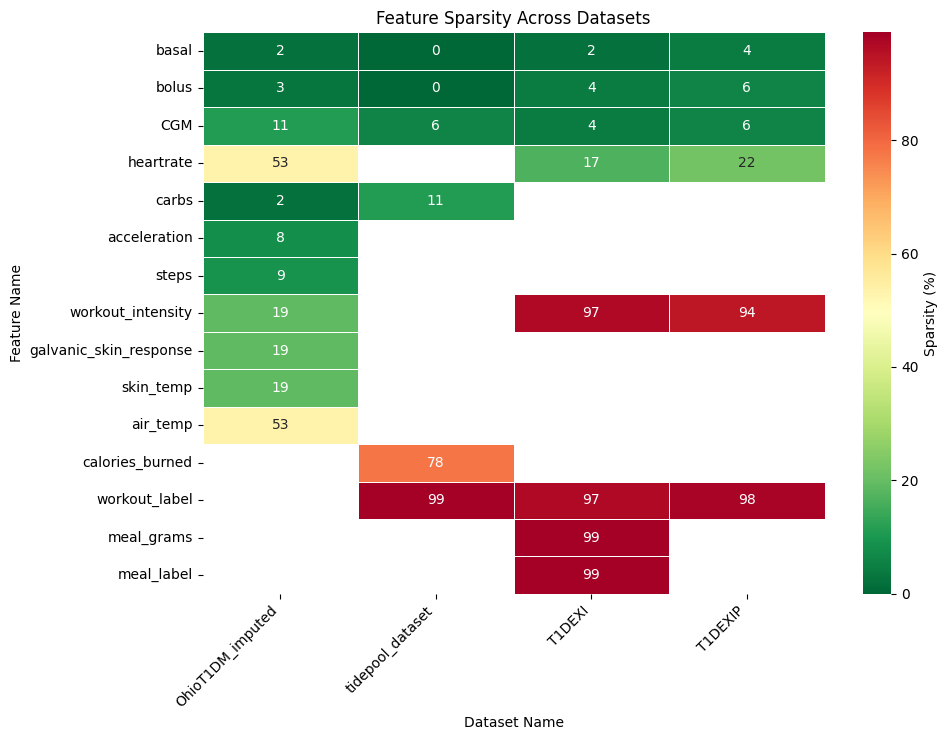

In [74]:
draw_sparsity_matrix(datasets)